In [1]:
import pandas as pd
import csv
import os
import time
from collections import defaultdict
import numpy as np
import itertools
import db_structure
import networkx as nx
from imp import reload
import matplotlib.pyplot as plt
import utilities as u
%load_ext autoreload
%autoreload 2

In [4]:
DB = db_structure.DB('TOPICC')
all_columns = DB.get_all_columns()
repetitive_columns = DB.get_common_column_names()
non_repetitive_columns = [x for x in all_columns if x not in repetitive_columns]
exclude_columns = DB.exclude_columns_from_data_viz

column_label_to_obj = {f'{x.name}': x for x in non_repetitive_columns}

In [68]:
def get_col_obj(*args):
    args = [[] if x is None else x for x in args]
    args = u.flatten(args)
    return [column_label_to_obj[x] for x in args]

outcome_var_chosen = 'DeathMode'
ind_vars_chosen = ['Sex', 'Ethnicity']
current_col_obj_list = get_col_obj(outcome_var_chosen, ind_vars_chosen)
paths = DB.find_paths_multi_columns(current_col_obj_list)
df = DB.get_biggest_joined_df_option_from_paths(paths)

outcome_var_with_table = None
ind_vars_with_table = []
for col_obj in current_col_obj_list:
    for table in col_obj.tables:
        col_header = f'{col_obj.name}_[{table.name}]'
        if col_header in df.columns:
            if col_obj.name == outcome_var_chosen:
                outcome_var_with_table = col_header
            else:
                ind_vars_with_table.append(col_header)
all_vars_with_table = [outcome_var_with_table] + ind_vars_with_table
df = df.loc[:, all_vars_with_table]

In [74]:
g = df.groupby(ind_vars_with_table)[outcome_var_with_table]
g.value_counts().unstack().reset_index()

DeathMode_[DEATH],Sex_[HOSPITALADMIT],Ethnicity_[HOSPITALADMIT],Brain death,Failed resuscitation,Limitation of care,Withdrawal of care
0,Female,Hispanic or Latino,4,5,11,16
1,Female,Not Hispanic or Latino,4,14,6,32
2,Female,Unknown or Not Reported,5,8,3,25
3,Male,Hispanic or Latino,9,4,6,13
4,Male,Not Hispanic or Latino,8,15,12,32
5,Male,Unknown or Not Reported,5,7,8,23


In [55]:
df.groupby(vars_with_table[1:]).size().reset_index(name='Count')

,Sex_[HOSPITALADMIT],Ethnicity_[HOSPITALADMIT],Count
0,Female,Hispanic or Latino,36
1,Female,Not Hispanic or Latino,56
2,Female,Unknown or Not Reported,41
3,Male,Hispanic or Latino,32
4,Male,Not Hispanic or Latino,67
5,Male,Unknown or Not Reported,43


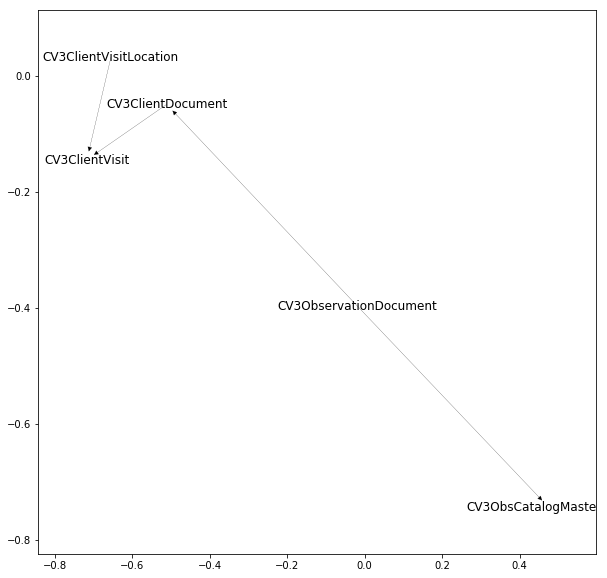

In [17]:
G = nx.DiGraph()
G.add_nodes_from(DB.tables.keys())
for current_table_name, current_table in DB.tables.items():
    for sibling in current_table.get_sibling_names():
        G.add_edge(current_table_name, sibling)
        G.add_edge(sibling, current_table_name)
    for child in current_table.get_children_names():
        G.add_edge(current_table_name, child)
plt.figure(figsize=(10,10))

#draw with networkx built-ins
nx.draw_networkx(G, node_shape="None", width=0.2)

#OR

#draw using pygraphviz
#A = nx.nx_agraph.to_agraph(G)
#H = nx.nx_agraph.from_agraph(A)
#nx.draw_spring(H, node_shape="None", with_labels=True, width=0.2)